In [227]:
%matplotlib inline 

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

import jax
import jax_cosmo as jc

import pyccl as ccl

In [228]:
# CCL 
cosmo_ccl = ccl.Cosmology(Omega_c=0.238, Omega_b=0.047, h=0.7, n_s=0.96, sigma8=0.8,
        Neff=0, transfer_function="eisenstein_hu", matter_power_spectrum="halofit")

# Jax-cosmo
cosmo_jax = jc.Cosmology(Omega_c=0.238, Omega_b=0.047, h=0.7, sigma8 = 0.8, n_s=0.96,
         Omega_k=0., w0=-1., wa=0.)

c = jc.constants.c

In [256]:
# Smail Parameters 
n_smail = 1.78e4 
a_smail = 1.64e0
b_smail = 3.73e0
z0_smail = 4.10e-1

zvec = np.arange(0.0, 0.5, 0.001)
avec = 1/(1+zvec)

nzvec = jc.redshift.smail_nz(a_smail, b_smail, z0_smail)

ellvec = np.linspace(0, 500, 101).astype(int)
ellvec[0] = 1

kvec = np.logspace(-4.0, np.log10(4.0), 2000)

bias = jc.bias.constant_linear_bias(1.0)
tracer_galaxy_clustering = jc.probes.NumberCounts([nzvec], bias) 


In [268]:
bias

(1.0,)

### Limber

In [257]:
cl_limber = jc.angular_cl.angular_cl(cosmo_jax, ellvec, [tracer_galaxy_clustering])

/Users/joaopedrobonifacio/anaconda3/envs/firecrown_developer/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


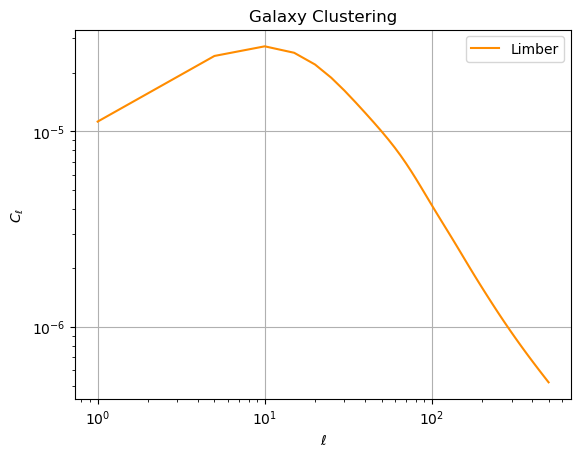

In [258]:
plt.plot(ellvec, cl_limber[0], color='darkorange' ,label='Limber')
plt.loglog()
plt.title('Galaxy Clustering')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.grid(True)
plt.legend()

### Non-Limber

In [232]:
def galaxy_clustering_kernel_integrand(chi, ell, k, dndz):
    
    j = sp.special.spherical_jn(ell, np.outer(k, chi), derivative=False)  # Spherical Bessel Function 
    window = sp.interpolate.splev(chi, dndz, ext=0)

    return window * j 

def cell_integrand(k, window1, window2):
    
    #pk = jc.power.nonlinear_matter_power(cosmo_jax, k, 1.0)
    pk = ccl.nonlin_matter_power(cosmo_ccl, k*cosmo_jax.h, 1.0)*cosmo_jax.h**3
    #pk = ccl.nonlin_matter_power(cosmo_ccl, k, 1.0)
    window1 = sp.interpolate.splev(k, window1, ext=0)
    window2 = sp.interpolate.splev(k, window2, ext=0)

    return pk * window1 * window2

def galaxy_clustering_non_limber_cl(chi, window_chi, kvec, ellvec, output_file_path):
    
    cl_gg = np.zeros(len(ellvec))

    for i, ell in enumerate(ellvec):
        galaxy_clustering_kernel = np.zeros(len(kvec))
        
        for k, kval in enumerate(kvec):
            galaxy_clustering_kernel[k] = sp.integrate.quad(galaxy_clustering_kernel_integrand, chi[0], chi[-1], args=(ell, kval, window_chi), limit=5000, epsrel=1e-6, epsabs=1e-12)[0]
        
        galaxy_clustering_spline = sp.interpolate.splrep(kvec, kvec*galaxy_clustering_kernel)

        cl_gg[i] = (2/np.pi) * sp.integrate.quad(cell_integrand, kvec[0], kvec[-1], args=(galaxy_clustering_spline, galaxy_clustering_spline), limit=5000, epsrel=1e-6, epsabs=1e-12)[0]
        print(ell, cl_gg[i])
        #break 

    np.savetxt(output_file_path, cl_gg, fmt="%g", header="Cl_gg")

    return cl_gg

In [253]:
file_path = '/Users/joaopedrobonifacio/Documents/lib/python/jax_cosmo/notebooks/cl_gg.csv'

chi = jc.background.radial_comoving_distance(cosmo_jax, avec)

#window_gg_z = tracer_galaxy_clustering.kernel(cosmo_jax, zvec, ellvec)[0]

window_gg_chi = sp.interpolate.splrep(chi, nzvec(zvec) * jc.background.growth_factor(cosmo_jax, avec) * jc.background.H(cosmo_jax, avec) / c / (zvec[1] - zvec[0]) / np.sum(nzvec(zvec))) 

In [ ]:
cl_non_limber = galaxy_clustering_non_limber_cl(chi, window_gg_chi, kvec, ellvec, file_path)

In [254]:
cl_non_limber = pd.read_csv(file_path)
cl_non_limber = cl_non_limber['# Cl_gg'].values

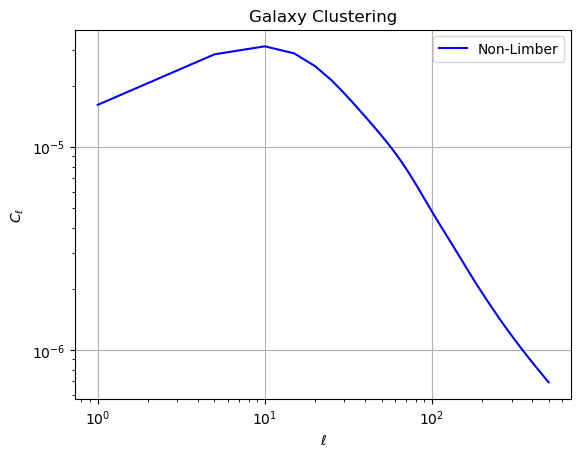

In [255]:
plt.plot(ellvec, cl_non_limber, color='blue', label='Non-Limber')
plt.loglog()
plt.title('Galaxy Clustering')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.grid(True)
plt.legend()

### Comparison

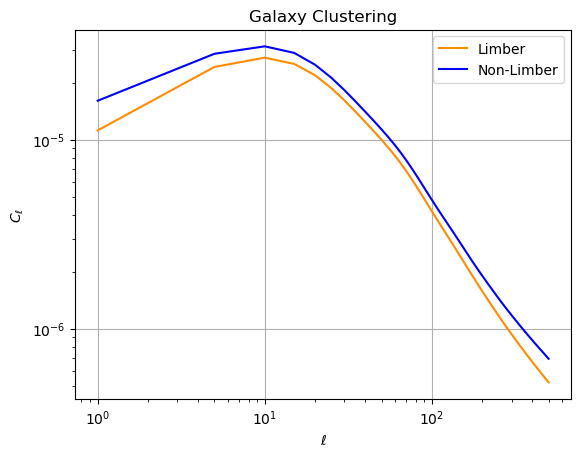

In [259]:
plt.plot(ellvec, cl_limber[0], color='darkorange' ,label='Limber')
plt.plot(ellvec, cl_non_limber, color='blue', label='Non-Limber')
plt.loglog()
plt.title('Galaxy Clustering')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.grid(True)
plt.legend()

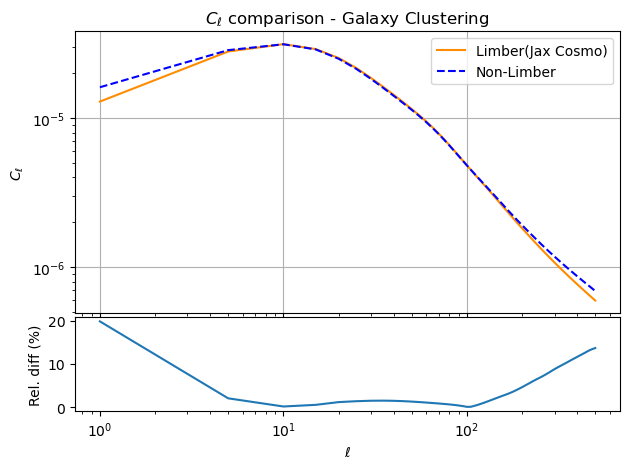

In [297]:
# Relative difference

factor = 1.15

rel_diff = (np.abs(cl_limber*factor - cl_non_limber) / cl_non_limber) * 100

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
a0.set_title("$C_{\ell}$ comparison - Galaxy Clustering")
a0.plot(ellvec, cl_limber[0]*factor, ls='-', label='Limber(Jax Cosmo)', color = 'darkorange')
a0.plot(ellvec, cl_non_limber, ls='--', label = 'Non-Limber', color='blue')
a0.grid()
a0.set_yscale("log")
a0.set_xscale("log")
a0.set_ylabel("$C_{\ell}$")
a0.legend()
a1.plot(ellvec, rel_diff[0])
a1.set_xlabel("$\ell$")
a1.set_ylabel("Rel. diff (%)")
#a1.set_xlim(0.18, 0.5)
#a1.set_yscale("log")
f.tight_layout()
plt.subplots_adjust(hspace=0.02)

### CCL Comparison 

In [272]:
tracer_ccl = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(zvec, nzvec(zvec)), bias=(zvec, np.ones(len(zvec))))

cl_ccl = ccl.angular_cl(cosmo_ccl, tracer_ccl, tracer_ccl, ellvec)

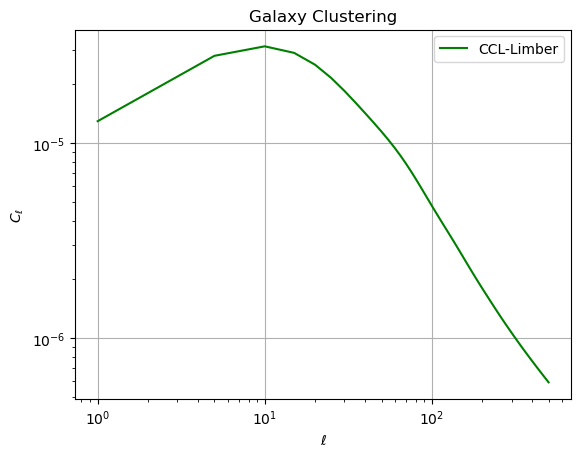

In [275]:
plt.plot(ellvec, cl_ccl, color='green', label='CCL-Limber')
plt.loglog()
plt.title('Galaxy Clustering')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.grid(True)
plt.legend()

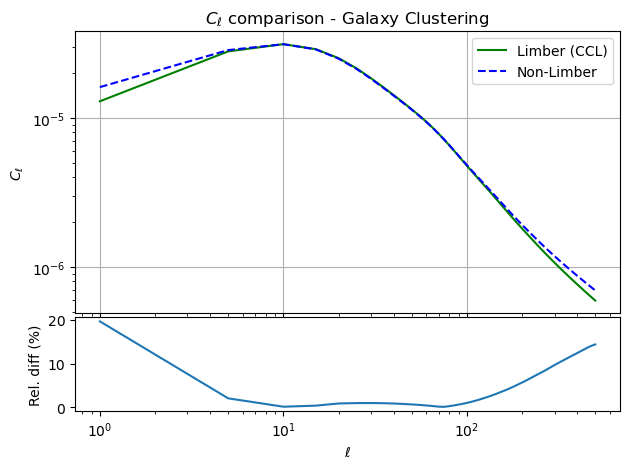

In [280]:
# Relative difference


rel_diff = (np.abs(cl_ccl - cl_non_limber) / cl_non_limber) * 100

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
a0.set_title("$C_{\ell}$ comparison - Galaxy Clustering")
a0.plot(ellvec, cl_ccl, ls='-', label='Limber (CCL)', color = 'green')
a0.plot(ellvec, cl_non_limber, ls='--', label = 'Non-Limber', color='blue')
a0.grid()
a0.set_yscale("log")
a0.set_xscale("log")
a0.set_ylabel("$C_{\ell}$")
a0.legend()
a1.plot(ellvec, rel_diff)
a1.set_xlabel("$\ell$")
a1.set_ylabel("Rel. diff (%)")
#a1.set_xlim(0.18, 0.5)
#a1.set_yscale("log")
f.tight_layout()
plt.subplots_adjust(hspace=0.02)

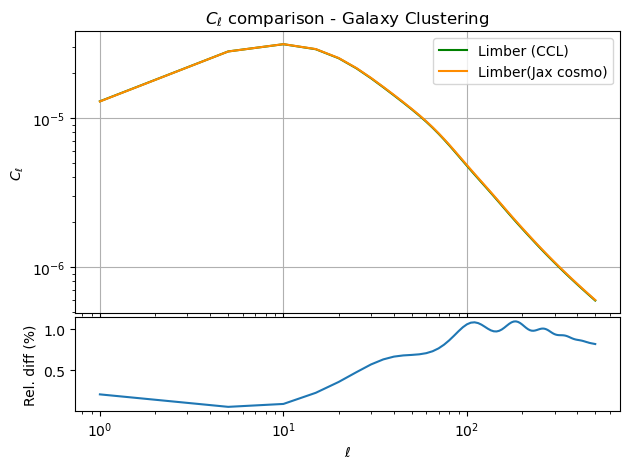

In [296]:
# Relative difference


rel_diff = (np.abs(cl_limber[0]*1.15 - cl_ccl) / cl_ccl) * 100

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
a0.set_title("$C_{\ell}$ comparison - Galaxy Clustering")
a0.plot(ellvec, cl_ccl, ls='-', label='Limber (CCL)', color = 'green')
a0.plot(ellvec, cl_limber[0]*1.15, ls='-', label = 'Limber(Jax cosmo)', color='darkorange')
a0.grid()
a0.set_yscale("log")
a0.set_xscale("log")
a0.set_ylabel("$C_{\ell}$")
a0.legend()
a1.plot(ellvec, rel_diff)
a1.set_xlabel("$\ell$")
a1.set_ylabel("Rel. diff (%)")
#a1.set_xlim(0.18, 0.5)
#a1.set_yscale("log")
f.tight_layout()
plt.subplots_adjust(hspace=0.02)